# Computable Phenotype - Homelessness
Jack Rossi and Anurima Sharma

## 1. Define Population for Training Data

This project seeks to define the characteristics in electronic medical records that indicate that a person is experiencing homelessness. We seek to define, understand, and intervene on this population, especially homeless patients who are very sick and/or highly utilize inpatient services.

We will identify a subset of patients in the study period who have 3 or more inpatient admissions in any 1-year period. A chart review will then be completed for these patients to idenify which of them are experiencing homelessness.

In [2]:
import pandas as pd

In [2]:
adm = pd.read_csv('lmh admissions.csv')
adm["synth_date"] = pd.to_datetime(adm.loc[:,"synth_date"]).dt.date
adm = adm.sort_values(by = 'synth_date')

In [3]:
adm.head()

,synth_id,synth_date
44834,171538957,2014-01-05
35905,1008244996,2014-01-10
37561,1896715568,2014-01-15
37601,631697669,2014-01-15
33123,956115776,2014-01-16


#### Find all patients with 3+ admits in a year-long span

In [4]:
window = pd.to_timedelta(365, 'd')
ids = adm.loc[:,'synth_id'].tolist()
synth_date = adm.loc[:,'synth_date'].tolist()

patients = []
#loop throuhg each date, defining the year beginning on that day
for d in list(set(synth_date)):
    #get list of admissions between date d and date d + window; count number of each ID
    numAdmByPat = adm.loc[((adm['synth_date'] < d + window) & (adm['synth_date'] >= d)),'synth_id'].value_counts()
    patsThreePlus = list(numAdmByPat.index[numAdmByPat >= 3])
    patients.extend(patsThreePlus)

In [9]:
patient_set = set(patients)
print('There are {} patients who were admitted 3 or more times in a year span.'.format(len(patient_set)))

There are 913 patients who were admitted 3 or more times in a year span.


#### Validation - patients admitted 3+ times in a calendar year.

In [6]:
#create a column for the year of the admission
adm['Year'] = adm['synth_date'].map(lambda x: x.year)
#count the number of admission dates for each year and patient
admByYear = adm.groupby(by = ['Year','synth_id']).count()

In [11]:
#find patients who've had 3 or more
admByYear1 = admByYear.loc[admByYear['synth_date'] >= 3].reset_index()
patient_set1 = set(admByYear1.loc[:,'synth_id'])
print('There are {} patients who were admitted 3+ times in a calendar year.'.format(len(patient_set1)))

There are 631 patients who were admitted 3+ times in a calendar year.


#### Validation - patients who were admitted 3+ in a year span, but not calendar year.

In [14]:
patient_set.difference(patient_set1)

{25209670,
 25448643,
 30708806,
 31569564,
 34549340,
 57638971,
 63302070,
 64002924,
 71538267,
 79642394,
 83898215,
 91638118,
 91954940,
 98227342,
 108971290,
 111441205,
 112460299,
 116592038,
 122049363,
 127879980,
 154554168,
 162749199,
 164333826,
 165158584,
 167856983,
 194736040,
 200384996,
 201415040,
 206405851,
 218372888,
 230831747,
 238297392,
 240030363,
 240837192,
 241352037,
 260388794,
 261913852,
 274209750,
 277395607,
 299395574,
 300749248,
 302434324,
 305546191,
 307982246,
 315284609,
 325368638,
 332732535,
 348254844,
 350038258,
 353951241,
 357371922,
 357580279,
 358420792,
 365162658,
 389893288,
 390859504,
 399750255,
 414498035,
 421426315,
 421555621,
 422705517,
 425142292,
 428421773,
 435675520,
 456469066,
 458706285,
 471392823,
 475713699,
 479226567,
 495297011,
 498245766,
 503775766,
 514724741,
 522476968,
 534842521,
 537429615,
 549705040,
 550979882,
 564824727,
 574588395,
 574694407,
 577486715,
 578152965,
 591967595,
 59273

## Construction of Homeless Address Indicators

"The homeless address indicators were based on six sources: (1) a comprehen- sive directory of shelter and single-site supportive housing programs provided by housing program staff from Hennepin and Ramsey Counties in response to an open-ended inquiry by electronic mail. We added several other address types noted by local homeless experts to this directory, including (2) the General Delivery Address (GDA)— a free service offered by the U.S. Postal Service for an individual’s mail to be held at the post office; (3) addresses of local homeless service centers collecting mail for homeless clients; (4) free text responses (e.g., “homeless”) recorded in the mailing address section of Medicaid enrollment records synonymous with homelessness; and (5) addresses of institutions commonly used by homeless individuals, including hotels, places of worship, and hospitals (Zech et al. 2015). Finally, (6) within the data, we observed frequent use of the addresses of county administrative offices and added these locations to the directory." (Vickery, 2018)

"
Category   Includes
Keyword    Addresses that include a variant of keywords “homeless” and “undomiciled” 
Hospital   Addresses of health care facilities participating in Healthix
Shelter    Addresses of 270 shelters in New York City and Long Island    
Worship    Addresses of 9677 places of worship in New York City and Long Island
" (Zech, 2015)

In [28]:
# estimating number of shelters between the boroughs
shelters = pd.read_json('https://data.cityofnewyork.us/resource/3qem-6v3v.json')
# shelters.groupby('borough')['']
print('Shelters by borough:')
print(shelters.reset_index().groupby('borough').count()['index'])
print('Total shelters {}'.format(shelters.shape[0]))
shelters.head()

Shelters by borough:
borough
Bronx            204
Brooklyn         272
Manhattan        187
Queens           204
Staten Island     17
Name: index, dtype: int64
Total shelters 884


,report_date,borough,community_district,adult_family_shelter,adult_shelter,fwc_cluster,fwc_comm_hotel,fwc_shelter,adult_shelter_comm_hotel,adult_family_comm_hotel
0,2020-01-31T00:00:00.000,Bronx,201,1.0,2.0,4.0,1.0,7.0,NaN,NaN
1,2020-01-31T00:00:00.000,Staten Island,501,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,2020-01-31T00:00:00.000,Queens,414,1.0,NaN,NaN,1.0,1.0,NaN,NaN
3,2020-01-31T00:00:00.000,Queens,413,NaN,NaN,NaN,2.0,2.0,5.0,NaN
4,2020-01-31T00:00:00.000,Queens,412,1.0,4.0,NaN,3.0,6.0,7.0,NaN


In [15]:
# family shelter performance
shelPerf = pd.read_json('https://data.cityofnewyork.us/resource/y7z5-rhh5.json')
shelPerf

,year_quarter,facility_name,provider_agency,performance_tier
0,2012 Q4,Clinton Family Inn,Homes for the Homeless,1st Performance Tier
1,2012 Q4,CRF House East,Children's Rescue Fund,1st Performance Tier
2,2012 Q4,HB - LaGuardia Family Center,"Housing Bridge, Inc.",1st Performance Tier
3,2012 Q4,HB - New Broadway,"Housing Bridge, Inc.",1st Performance Tier
4,2012 Q4,HELP- Bronx Morris,HELP U.S.A,1st Performance Tier
...,...,...,...,...
134,2013 Q1,Providence House 7,"Providence House, Inc.",6th Performance Tier
135,2013 Q1,St. John's Place Family Residence,Settlement Housing Fund,6th Performance Tier
136,2013 Q1,Stockholm Family Residence,SCO,6th Performance Tier
137,2013 Q1,Theresa Haven,Family Support System,6th Performance Tier


In [18]:
# NYC Health + Hospitals Locations
nychealth = pd.read_json('https://data.cityofnewyork.us/resource/ymhw-9cz9.json')
nychealth
print('NYC Health + Hospitals by borough')
print(nychealth.reset_index().groupby('borough').count()['index'])

NYC Health + Hospitals by borough
borough
Bronx            14
Brooklyn         26
Manhattan        24
Queens           11
Staten Island     3
Name: index, dtype: int64


In [3]:
short_list_data = pd.read_json('https://data.cityofnewyork.us/resource/bmxf-3rd4.json')

In [4]:
short_list_data

,center_name,borough,address,comments,postcode,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,Mainchance,Manhattan,120 East 32nd Street\n,Open 24 hours,10016,40.745377,-73.981306,5,2,72,1018469,1008870087,Murray Hill-Kips Bay ...
1,The Living Room,Bronx,1241 Lafayette Avenue\n,Open 24 hours,10474,40.816530,-73.889742,2,17,93,2006002,2027400100,Hunts Point ...
2,Olivieri Center,Manhattan,257 West 30th Street\n,Open from 7:30 a.m.-8:30 p.m. This program rem...,10001,40.749139,-73.994016,5,3,101,1014337,1007800009,Midtown-Midtown South ...
3,The Gathering Place,Brooklyn,2402 Atlantic Avenue\n,Open from 7:30 a.m.-8:30 p.m. This program rem...,11233,40.676015,-73.905105,16,37,36502,3038666,3014370008,Ocean Hill ...
4,Project Hospitality,Staten Island,25 Central Avenue\n,Open from 7:30 a.m.-8:30 p.m. This program rem...,10301,40.641112,-74.076825,1,49,3,5000027,5000050065,West New Brighton-New Brighton-St. George ...


## Exploring Medical Note Sections


In [10]:
from util import load_dbmi
import numpy as np

In [15]:
filename = r'data/smokers_surrogate_train_all_version2.xml'
notes, smoking = load_dbmi(filename, mode = 'smoking')
set(smoking)

{'CURRENT SMOKER', 'NON-SMOKER', 'PAST SMOKER', 'SMOKER', 'UNKNOWN'}

In [21]:
print(np.mean('"SOCIAL HISTORY" section is present in {} of notes.'.format([1 if "SOCIAL HISTORY" in note else 0 for note in notes])))

count = 0
for i in range(len(smoking)):
    if (smoking[i] in ['CURRENT SMOKER', 'PAST SMOKER', 'SMOKER']) and ("SOCIAL HISTORY" in notes[i]):
        count += 1

print(count/sum([1 if smok in ['CURRENT SMOKER', 'PAST SMOKER', 'SMOKER'] else 0 for smok in smoking]))

0.28391959798994976
0.2864321608040201
0.625


## Parsing Physician Notes

The following code segments parses clinical notes, vectorizises them, and then implements a variety of machine learning algorithms to classify and cluster similar notes. Currently, the data being used focuses on smokers and non-smokers, but soon we will use data that focuses on homeless and house patients. One clustering method, K-Means Clutering, and 3 classification methods, K-Nearest Neighbors, Logistic Regression, and a Neural Network approach, are implemented below.

In [1]:
#Load util files and word embeddings

from utilOld import load_dbmi, load_deid, load_smoking
import numpy as np
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
#word2vec = gensim.models.KeyedVectors.load_word2vec_format("PubMed-w2v.bin", binary=True)
print("Loaded word vectors successfully!")

Loaded word vectors successfully!


In [2]:
#Load data and separate smoker and non-smoker notes

id_data = load_dbmi("data/test_deid_surrogate_train_all_version2.xml", mode='deid')
smoker_data = load_dbmi("data/smokers_surrogate_train_all_version2.xml", mode = 'smoking')
id_data = [i.replace('\n','') for i in id_data]
smoker_data = [i.replace('\n','') for i in smoker_data] 
        
smoker_notes = []
non_smoker_notes = []
for i in id_data:
    if "smoker" in i:
        smoker_notes.append(i)
    else:
        non_smoker_notes.append(i)
        
for i in smoker_data:
    if "smoker" in i:
        smoker_notes.append(i)
    else:
        non_smoker_notes.append(i)

all_notes = smoker_notes + non_smoker_notes

print(str(len(non_smoker_notes)) + ', ' + str(len(smoker_notes)))

1033, 33


In [3]:
#Tokenize notes
'''
#Preprocessing Notes -- Made the off the shelf methods WORSE
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

smoker_tokens=[]
for line in smoker_notes: 
    #remove stopwords
    line = line.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(line)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    my_string = ' '.join(tokens)
    smoker_tokens.append(my_string)

non_smoker_tokens=[]
for line in non_smoker_notes: 
    #remove stopwords
    line = line.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(line)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    my_string = ' '.join(tokens)
    non_smoker_tokens.append(my_string)
'''

"\n#Preprocessing Notes -- Made the off the shelf methods WORSE\nimport nltk\nnltk.download('wordnet')\nfrom nltk.corpus import wordnet\nfrom nltk.stem import WordNetLemmatizer \nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import RegexpTokenizer\n\nsmoker_tokens=[]\nfor line in smoker_notes: \n    #remove stopwords\n    line = line.lower()\n    tokenizer = RegexpTokenizer(r'\\w+')\n    tokens = tokenizer.tokenize(line)\n    tokens = [word for word in tokens if word not in stopwords.words('english')]\n    my_string = ' '.join(tokens)\n    smoker_tokens.append(my_string)\n\nnon_smoker_tokens=[]\nfor line in non_smoker_notes: \n    #remove stopwords\n    line = line.lower()\n    tokenizer = RegexpTokenizer(r'\\w+')\n    tokens = tokenizer.tokenize(line)\n    tokens = [word for word in tokens if word not in stopwords.words('english')]\n    my_string = ' '.join(tokens)\n    non_smoker_tokens.append(my_string)\n"

In [4]:
#Vectorize Smoker and Non-Smoker Notes
def doc_to_vec(sentence, word2vec):
    # get list of word vectors in sentence
    word_vecs = [word2vec.get_vector(w) for w in sentence.split() if w in word2vec.vocab]
    # return average
    stack = np.asarray(word_vecs).mean(0)
    if stack.all() != None:
        return np.stack(stack)
                    
smoker_notes_vec = np.array([doc_to_vec(i, word2vec) for i in smoker_notes])
non_smoker_notes_vec = np.array([doc_to_vec(i, word2vec) for i in non_smoker_notes[500:]])
#There is an issue with one of the non-smoker notes beween indexes 30 and 40... Hence the arbitrary division of data

print(smoker_notes_vec.shape)
print(non_smoker_notes_vec.shape)

(33, 300)
(533, 300)


33
566


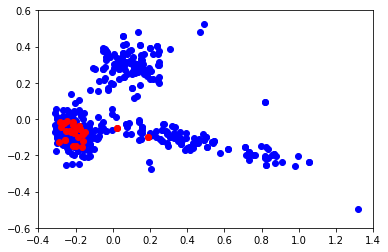

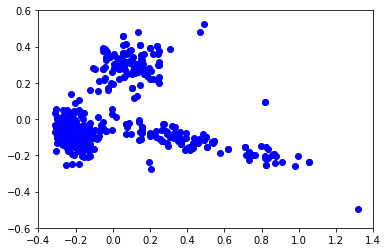

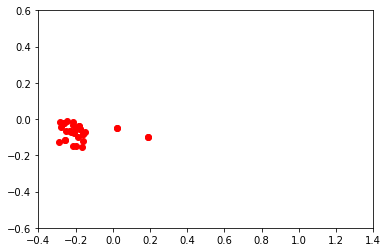

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Creating lables, or a y array, for the daya
allData = []
yLabels = []

for i in smoker_notes_vec:
    allData.append(i)
    yLabels.append(0)
print(len(allData))
for i in non_smoker_notes_vec:
    allData.append(i)
    yLabels.append(1)
print(len(allData))
#PCA so the data can be plotted 
pca = PCA(n_components=2)

allDataPCA = pca.fit_transform(allData)

#Plotting Smoker and Non-Smoker Data on the same graph
plt.scatter(*zip(*allDataPCA[34:]), color='blue')
plt.scatter(*zip(*allDataPCA[:34]), color='red')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()

'''
plt.scatter(*zip(*allDataPCA[34:]), color='blue')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()

plt.scatter(*zip(*allDataPCA[:34]), color='red')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()
'''

0.9393939393939394


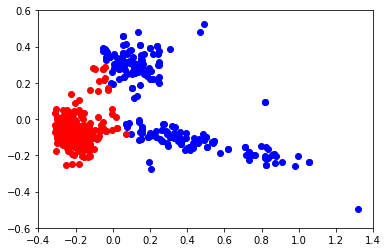

In [7]:
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(allDataPCA)

rightSmoker = 0
for i in range(len(y_pred)):
    if yLabels[i] == 0:
        if y_pred[i] == yLabels[i]:
            rightSmoker += 1

accuracy = rightSmoker/33 #There are 192 totoal test notes, 33 smoker and 192-33 non-smoker
print(accuracy)

class1 = []
class2 = []

for a in range(len(allDataPCA)-1):
    if y_pred[a] == 0:
        class1.append(allDataPCA[a])
    else:
        class2.append(allDataPCA[a])

plt.scatter(*zip(*class2), color='blue')
plt.scatter(*zip(*class1), color='red')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()

In [8]:
# 60/40 Train Test split -- Anu, clean this up a bit thanks
train_data = []
yLabels_train = []

for i in range(int(len(smoker_notes_vec)*.6)):
    train_data.append(allDataPCA[i])
    yLabels_train.append(0)
for i in range(int(len(smoker_notes_vec)),int(len(allData)*.6)):
    train_data.append(allDataPCA[i])
    yLabels_train.append(1)
    
test_data = []
yLabels_test = []

for i in range(int(len(smoker_notes_vec)*.6),int(len(smoker_notes_vec))):
    test_data.append(allDataPCA[i])
    yLabels_test.append(0)
print(len(test_data))
for i in range(int(len(allData)*.6),int(len(allData))):
    test_data.append(allDataPCA[i])
    yLabels_test.append(1)
print(len(test_data))

14
241


241
0.42857142857142855


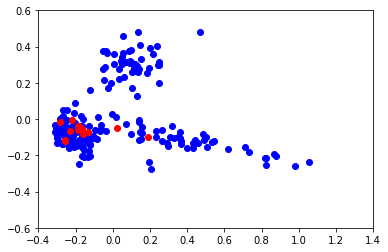

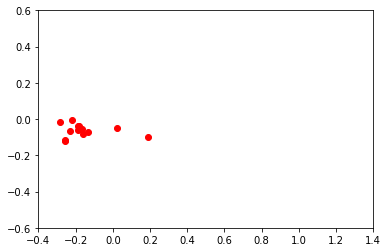

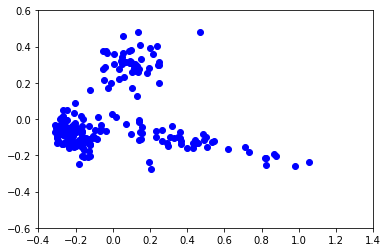

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(train_data, yLabels_train)

y_pred = knn.predict(test_data)
print(len(test_data))

rightSmoker = 0
for i in range(len(y_pred)):
    if yLabels_test[i] == 0:
        if y_pred[i] == yLabels_test[i]:
            rightSmoker += 1

accuracy = rightSmoker/14 #There are 241 totoal test notes, 14 smoker and 241-14 non-smoker
print(accuracy)

class1 = []
class2 = []

for a in range(len(test_data)-1):
    if y_pred[a] == 0:
        class1.append(test_data[a])
    else:
        class2.append(test_data[a])

plt.scatter(*zip(*class2), color='blue')
plt.scatter(*zip(*class1), color='red')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()

'''
plt.scatter(*zip(*class1), color='red')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()

plt.scatter(*zip(*class2), color='blue')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()
'''

In [12]:
#logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(train_data, yLabels_train)
#print(clf.predict(test_data))
#print(clf.score(test_data, yLabels_test))

#Predicts all notes to be non-smoker notes

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
# 60/40 Train Test split with non-PCA Data -- Anu, clean this up a bit thanks

train_data_keras = []
yLabels_train_keras = []

for i in range(int(len(smoker_notes_vec)*.6)):
    train_data_keras.append(allData[i])
    yLabels_train_keras.append(0)
for i in range(int(len(smoker_notes_vec)),int(len(allData)*.6)):
    train_data_keras.append(allData[i])
    yLabels_train_keras.append(1)
    
test_data_keras = []
yLabels_test_keras = []

for i in range(int(len(smoker_notes_vec)*.6), int(len(smoker_notes_vec))):
    test_data_keras.append(allData[i])
    yLabels_test_keras.append(0)
print(len(test_data_keras))
for i in range(int(len(allData)*.6),len(allData)):
    test_data_keras.append(allData[i])
    yLabels_test_keras.append(1)
print(len(test_data_keras))

train_data_keras = np.asarray(train_data_keras)
yLabels_train_keras = np.asarray(yLabels_train_keras)
test_data_keras = np.asarray(test_data_keras)
yLabels_test_keras = np.asarray(yLabels_test_keras)

14
241


In [15]:
#Neural Network Implementation
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=0)

model = Sequential()
model.add(Dense(128, input_dim=300, activation='relu'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(train_data_keras, yLabels_train_keras, epochs=100, batch_size=5, verbose=1)
y_pred_keras = model.predict_proba(test_data_keras)
#for i in range(len(test_data_keras)):
    #print("X=%s, Predicted=%s" % (yLabels_test_keras[i], y_pred_keras[i]))

Epoch 1/100
325/325 [==============================] - 2s 6ms/step - loss: 0.0640
Epoch 2/100
325/325 [==============================] - 1s 2ms/step - loss: 0.0734
Epoch 3/100
325/325 [==============================] - 1s 3ms/step - loss: 0.0728
Epoch 4/100
325/325 [==============================] - 1s 2ms/step - loss: 0.0572
Epoch 5/100
325/325 [==============================] - 1s 3ms/step - loss: 0.0621
Epoch 6/100
325/325 [==============================] - 1s 3ms/step - loss: 0.0660
Epoch 7/100
325/325 [==============================] - 1s 2ms/step - loss: 0.0596
Epoch 8/100
325/325 [==============================] - 1s 2ms/step - loss: 0.0630
Epoch 9/100
325/325 [==============================] - 1s 3ms/step - loss: 0.0649
Epoch 10/100
325/325 [==============================] - 1s 2ms/step - loss: 0.0651
Epoch 11/100
325/325 [==============================] - 1s 2ms/step - loss: 0.0715
Epoch 12/100
325/325 [==============================] - 0s 1ms/step - loss: 0.0558
Epoch 13/100


325/325 [==============================] - 1s 2ms/step - loss: 9.7082e-05
Epoch 99/100
325/325 [==============================] - 1s 2ms/step - loss: 1.2309e-04
Epoch 100/100
325/325 [==============================] - 1s 2ms/step - loss: 1.0806e-04


//anaconda3/lib/python3.7/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


241
0.9543568464730291


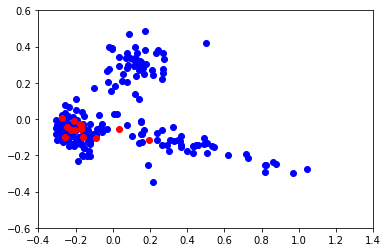

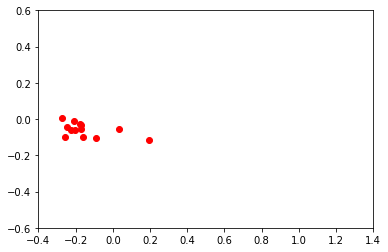

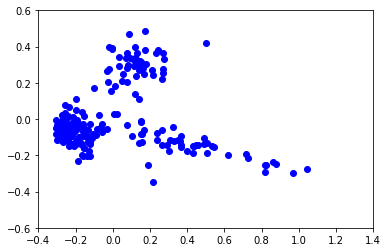

In [20]:
rightSmoker = 0
print(len(y_pred_keras))
for i in range(len(y_pred_keras)):
    #if yLabels_test_keras[i] == 1:
    if round(y_pred_keras[i][0]) == yLabels_test_keras[i]:
        rightSmoker += 1

accuracy = rightSmoker/(241) #There are 241 totoal test notes, 14 smoker and 241-14 non-smoker
print(accuracy)


test_data_keras_PCA = pca.fit_transform(test_data_keras)
class1 = []
class2 = []

for a in range(len(test_data)-1):
    if round(y_pred_keras[a][0]) == 0:
        class1.append(test_data_keras_PCA[a])
    else:
        class2.append(test_data_keras_PCA[a])
                         
plt.scatter(*zip(*class2), color='blue')
plt.scatter(*zip(*class1), color='red')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()

'''
plt.scatter(*zip(*class1), color='red')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()

plt.scatter(*zip(*class2), color='blue')
plt.xlim(-.4, 1.4)
plt.ylim(-.6, .6)
plt.show()
'''